In [1]:
# CMSE Project
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import random as random
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.formula.api as smf

Reading in the data and spitting out some basic info about its structure.

In [2]:
# Reading in Data
# Keys to extract formatted State and County names
key = pd.read_excel('fips_codes_website.xls')   # Counties and major cities
key00 = pd.read_csv('FIPS_countycodes.txt',delimiter=',')  # Counties only
key00['GU Name'] = key00['GU Name'].str[:-7]  # Slice 'county' from names
# Housing Data
zillow2019 = pd.read_excel("County_Zhvi_Summary_AllHomes2019.xls")
zillow2019['RegionName'] = zillow2019['RegionName'].str[:-7]  # Slice 'county' from names
# Crime
crime2010 = pd.read_csv('33523-0001-crimedata2010.txt',delimiter='\t')
crime2012 = pd.read_csv('35019-0001-crimedata2012.txt',delimiter='\t')
crime2014 = pd.read_csv('36399-0001-crimedata2014.txt',delimiter='\t')
crime2016 = pd.read_csv('37059-0001-crimedata2016.txt',delimiter='\t')
# Enumployment & Wages
#test_wages_18 = pd.read_excel('allhlcn183.xlsx',sheet_name='US_St_Cn_MSA')
wage_unemp2018 = pd.read_csv('allhlcn183wage_unemp2018.txt',delimiter='\t',dtype={'St':str})
wage_unemp2016 = pd.read_csv('allhlcn163wage_unemp2016.txt',delimiter='\t',dtype={'St':str})
wage_unemp2014 = pd.read_csv('allhlcn143wage_unemp2014.txt',delimiter='\t',dtype={'St':str})
wage_unemp2012 = pd.read_csv('allhlcn123wage_unemp2012.txt',delimiter='\t',dtype={'St':str})
wage_unemp2010 = pd.read_csv('allhlcn103wage_unemp2010.txt',delimiter='\t',dtype={'St':str})

print("2014 crime:",crime2014.shape,"// key:",key.shape)
print("2019 Housing:",zillow2019.shape)
print('2018 Wages:',wage_unemp2018.shape)
x = ((crime2014.shape[0])*(crime2014.shape[1]))*4 + ((wage_unemp2018.shape[0])*(wage_unemp2018.shape[1]))*5 + (key00.shape[0])*key00.shape[1]
print(x,'unique datapoints in all datasets')

2014 crime: (3177, 56) // key: (41787, 7)
2019 Housing: (1921, 17)
2018 Wages: (62724, 21)
7313843 unique datapoints in all datasets


Here is where I did all my data cleaning and minutiae for the search function.

In [3]:
def crime_cleaner(data):
    # Merge key with crime db to gain state / city names
    washing = data.merge(key00,left_on=['FIPS_CTY','FIPS_ST'], right_on=['County FIPS Code','State FIPS Code'])
    # Rearrange columns
    # for 'key'
    #washing = washing[['STUDYNO','EDITION','PART','IDNO','FIPS_ST','State FIPS Code','State Abbreviation','FIPS_CTY','County FIPS Code','GU Name','Entity Description','CPOPARST','AG_ARRST','JURFLAG','COVIND', 'GRNDTOT','P1TOT','P1VLNT','P1PRPTY','MURDER','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY','FIPS Entity Code','ANSI Code']]
    # for 'key00'
    washing = washing[['STUDYNO','EDITION','PART','IDNO','FIPS_ST','State FIPS Code','State Abbreviation','FIPS_CTY','County FIPS Code','GU Name','CPOPARST','AG_ARRST','JURFLAG','COVIND', 'GRNDTOT','P1TOT','P1VLNT','P1PRPTY','MURDER','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY']]
    
    # Select only wanted columns
    clean = washing[['State Abbreviation','GU Name','MURDER','P1TOT','P1VLNT','P1PRPTY','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY']]
    return clean
def wage_cleaner(data):
    # Drop Unwanted columns
    base = data.drop(['Area\nCode','Own','NAICS','Qtr','Status Code'],axis=1)
    # Select County level data
    washing = base.loc[(base['Area Type'] == 'County')]
    washing['Cnty'] = washing['Cnty'].astype('int64') # Convert to int for merging // Throws error
    washing['St'] = washing['St'].astype('int64')    # Convert to into for merging // Throws error
    # Merge with key
    washing = washing.merge(key00,left_on=['St','Cnty'], right_on=['State FIPS Code','County FIPS Code'])
    # Rearrange columns and drop unwanted columns
    county_wages = washing[['State Abbreviation','GU Name', 'Year', 'Area Type', 'St Name', 'Area', 'Ownership','Industry', 'Establishment Count', 'July Employment','August Employment', 'September Employment', 'Total Quarterly Wages','Average Weekly Wage', 'Employment Location Quotient Relative to U.S.','Total Wage Location Quotient Relative to U.S.']]
    county_wages['Establishment Count'] = county_wages['Establishment Count'].str.replace(',','')  # Get rid of comma // Throws Error
    county_wages['Establishment Count'] = pd.to_numeric(county_wages['Establishment Count'])   # Convert to interger // Throws Error
    county_wages['September Employment'] = county_wages['September Employment'].str.replace(',','')  # Get rid of comma // Throws Error
    county_wages['September Employment'] = pd.to_numeric(county_wages['September Employment'])    # Convert to interger // Throws Error  
    county_wages['Average Weekly Wage'] = county_wages['Average Weekly Wage'].str.replace(',','')  # Get rid of comma // Throws Error
    county_wages['Average Weekly Wage'] = pd.to_numeric(county_wages['Average Weekly Wage'])  # Convert to interger // Throws Error
    county_wages['Industry'] = county_wages['Industry'].str.replace('0','') # Formatting to fix year 2018 industry codes
    county_wages['Industry'] = county_wages['Industry'].str.replace('1','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('2','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('3','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('4','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('5','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('6','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('7','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('8','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('9','')
    
    state_wages = base.loc[(base['Area Type'] == 'State')]   # State Level Wages
    nation_wages = base.loc[(base['Area Type'] == 'Nation')]    # Nation Level Data
    urban_wages = base.loc[(base['Area Type'] == 'MSA')]   # Metropolitan Level Data
    return county_wages,state_wages,nation_wages,urban_wages

def search(county,state):
    # Collect crime data from all years
    crime1 = crime10.loc[(crime10['GU Name'] == county) & (crime10['State Abbreviation'] == state)]
    crime2 = crime12.loc[(crime12['GU Name'] == county) & (crime12['State Abbreviation'] == state)]
    crime3 = crime14.loc[(crime14['GU Name'] == county) & (crime14['State Abbreviation'] == state)]
    crime4 = crime16.loc[(crime16['GU Name'] == county) & (crime16['State Abbreviation'] == state)]
    crime = crime1,crime2,crime3,crime4
    # Collect wage and firm data from all years :: wage[0] pulls county level data, change to pull state, national, or urban levels
    wage1 = wage10[0].loc[(wage10[0]['GU Name'] == county) & (wage10[0]['State Abbreviation'] == state)]
    wage2 = wage12[0].loc[(wage12[0]['GU Name'] == county) & (wage12[0]['State Abbreviation'] == state)]
    wage3 = wage14[0].loc[(wage14[0]['GU Name'] == county) & (wage14[0]['State Abbreviation'] == state)]
    wage4 = wage16[0].loc[(wage16[0]['GU Name'] == county) & (wage16[0]['State Abbreviation'] == state)]
    wage5 = wage18[0].loc[(wage18[0]['GU Name'] == county) & (wage18[0]['State Abbreviation'] == state)]
    wages = wage1,wage2,wage3,wage4,wage5
    return {'Crime':crime,'Industry':wages}

# Yearly cleaned databases
crime10 = crime_cleaner(crime2010)
crime12 = crime_cleaner(crime2012)
crime14 = crime_cleaner(crime2014)
crime16 = crime_cleaner(crime2016)
cols = list(crime14.columns.values) # Grab columns
# Cleaned Wage Data
wage10 = wage_cleaner(wage_unemp2010) # Returns 3 items; county, state, national, and urban level data sets
wage12 = wage_cleaner(wage_unemp2012)
wage14 = wage_cleaner(wage_unemp2014)
wage16 = wage_cleaner(wage_unemp2016)
wage18 = wage_cleaner(wage_unemp2018)

#wage18[0]['Industry'] = [i[i.find(' ')+1:] for i in wage18[0]['Industry']] # Get to work
wage18[0]['Industry'] = wage18[0]['Industry'].str[1:] # Remove first space in 2018 industry codes

C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

Selects 10 cities at random and all associated data

In [ ]:
# Selects 10 Random counties and stores them as a dictionary with relevant data // Key = MI, County
samp_db = {}
for n in range(10):
    r = random.randint(0,len(crime12))
    x = crime12['State Abbreviation'].iloc[r] # Pull State Abreviation
    y = crime12['GU Name'].iloc[r]  # Pull analogous county name
    z = x+', '+y # Format name for dictionary key
    agg = search(y,x) # Return criminal and economic data
    samp_db[z] = agg  # Add data to empty dictionary

Search function to return all criminal and economic data in the uploaded datasets; following cell blocks to extract and graph individual county data. 

Used to check integrity of sample database // **irrelevant to analysis though.**

In [8]:
# S E A R C H #
##############
print("IF USING 'KEY00', COUNTIES ONLY")
CountCit = input("Enter a county: ")
state = input("Enter a state abbreviation: ")

# Search indexing || Crime data 2010-2016, Wages 2010-2018,
collect = search(CountCit,state)
# Indexing of 'Collect' :: [crime / wages][data by year]

IF USING 'KEY00', COUNTIES ONLY
Enter a county: Orange
Enter a state abbreviation: CA


In [14]:
# Arrest Options
collect['Crime'][0].columns

Index(['State Abbreviation', 'GU Name', 'MURDER', 'P1TOT', 'P1VLNT', 'P1PRPTY',
       'RAPE', 'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 'MVTHEFT', 'ARSON',
       'OTHASLT', 'FRGYCNT', 'FRAUD', 'EMBEZL', 'STLNPRP', 'VANDLSM',
       'WEAPONS', 'COMVICE', 'SEXOFF', 'DRUGTOT', 'DRGSALE', 'COCSALE',
       'MJSALE', 'SYNSALE', 'OTHSALE', 'DRGPOSS', 'COCPOSS', 'MJPOSS',
       'SYNPOSS', 'OTHPOSS', 'GAMBLE', 'BOOKMKG', 'NUMBERS', 'OTGAMBL',
       'OFAGFAM', 'DUI', 'LIQUOR', 'DRUNK', 'DISORDR', 'VAGRANT', 'ALLOTHR',
       'SUSPICN', 'CURFEW', 'RUNAWAY'],
      dtype='object')

Average house price, 2019:  $ 723300
Metro areas: Los Angeles-Long Beach-Anaheim
{'DRGPOSS': (18439, 13500, 15344, 20667), 'AGASSLT': (4557, 4307, 4216, 4764), 'DUI': (15955, 14633, 12615, 10826)}


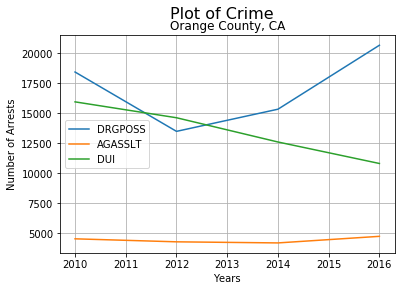

In [15]:
# Test Plotting & Collecting Specific Data
crimes = 'DRGPOSS','AGASSLT','DUI'
def searchcrime_cleaner(data,crimes,tsearch):
    container = []
    count = 0
    for i in range(len(data['Crime'])):
        knight = data['Crime'][count][tsearch].values
        container.append(knight)
        count += 1
    container = container[0][0],container[1][0],container[2][0],container[3][0]
    return container
# Pull cleaned crime data, store in dictionary
crime_dic = {}
for i in crimes:
    tsearch = i
    crime_dic[i] = searchcrime_cleaner(collect,crimes,tsearch)


name = collect['Crime'][0]['GU Name'].values, collect['Crime'][0]['State Abbreviation'].values
name = name[0]+" County, "+name[1]
years = (2010,2012,2014,2016)
#Plotting
for i in crime_dic:
    plt.plot(years,crime_dic[i],label=i)
    plt.suptitle("Plot of Crime",size=16)
    plt.title(name[0], size=12)
    plt.xlabel("Years")
    plt.ylabel("Number of Arrests")
    plt.grid()
    plt.legend()
#plt.savefig('name')
houdata = zillow2019.loc[(zillow2019['RegionName'].values == CountCit) & (zillow2019['State'].values == state)]
try:
    print("Average house price, 2019:  $",int(houdata['Zhvi']))
    print("Metro areas:",houdata['Metro'].values[0])
except:
    print('--No Housing Data Available For This County--')
print(crime_dic)

In [16]:
# Graphics for Industry and economic Data
collect['Industry'][0].columns    # Statistic options

Index(['State Abbreviation', 'GU Name', 'Year', 'Area Type', 'St Name', 'Area',
       'Ownership', 'Industry', 'Establishment Count', 'July Employment',
       'August Employment', 'September Employment', 'Total Quarterly Wages',
       'Average Weekly Wage', 'Employment Location Quotient Relative to U.S.',
       'Total Wage Location Quotient Relative to U.S.'],
      dtype='object')

In [17]:
# Function for cleaning data from search variable
def search_industrydata_cleaner(data,stat,tsearch):
    container = []
    count = 0
    for n in range(len(data['Industry'])):    # Loop for pulling data of multiple years      
        container.append(data['Industry'][n].loc[(data['Industry'][n]['Industry']==tsearch)][stat].values)
#                          dictionary//year       dictionary//year//column    comparison/DATA TO PULL
        count += 1
    container = container[0][0],container[1][0],container[2][0],container[3][0],container[4][0]
    return container # Return a list of individual values

# Function to find largest industries per county
def most_establishments(data):
    data = data.loc[(data['Industry'] != '10 Total, all industries')] # Remove Totals, 2018
    data = data.loc[(data['Industry'] != 'Total, all industries')] # Remove Totals, all other years
    data = data.nlargest(4,'Establishment Count')
    return data

industry = most_establishments(collect['Industry'][4])  # Returns 4 largest industries in 2018 ,index = 4
industrydata = industry # Data set for other metrics in largest industries
industry = list(industry['Industry']) # List of largest industries for reference purposes

{'Service-providing': (88430, 89012, 93859, 101601, 110501),
 'Education and health services': (10335, 10599, 27158, 30003, 35858),
 'Professional and business services': (18734, 18651, 20355, 20181, 21992),
 'Trade, transportation, and utilities': (16318, 16019, 16617, 16677, 17557)}

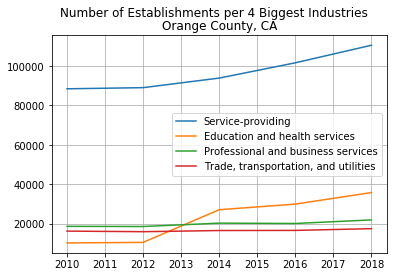

In [18]:
stat = 'Establishment Count'  
# Statistic associated with industry:: Establishment Count,Average Weekly Wage,September Employment
indus_dic = {}
for i in industry:
    tsearch = i
    rook = search_industrydata_cleaner(collect,stat,tsearch)
    indus_dic[i] = rook
# Plotting Searched Data
name = collect['Industry'][0]['GU Name'].values,collect['Industry'][0]['State Abbreviation'].values
name = name[0][0]+" County, "+name[1][0]
years = 2010,2012,2014,2016,2018
for i in industry:
    plt.plot(years,indus_dic[i],label=i)
    plt.suptitle('Number of Establishments per 4 Biggest Industries')
    plt.title(name)
    plt.legend()
plt.grid()
#plt.savefig('name')
indus_dic

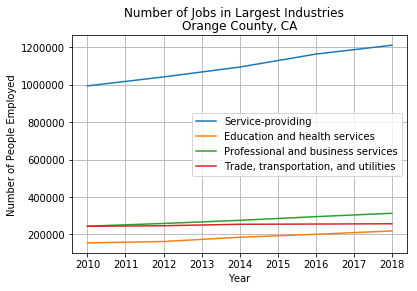

In [19]:
# Call Employment numbers
stat = 'September Employment'  
# Statistic associated with industry:: Establishment Count,Average Weekly Wage,September Employment
emp_dic = {}
for i in industry:
    tsearch = i
    rook = search_industrydata_cleaner(collect,stat,tsearch)
    emp_dic[i] = rook
# Plot
for i in industry:
    plt.plot(years,emp_dic[i],label=i)
    plt.suptitle('Number of Jobs in Largest Industries')
    plt.ylabel('Number of People Employed')
    plt.xlabel('Year')
    plt.title(name)
    plt.legend()
plt.grid()
#plt.savefig('Industries with most employed')

{'Service-providing': (917, 963, 979, 1090, 1082), 'Education and health services': (938, 933, 883, 975, 969), 'Professional and business services': (1091, 1131, 1207, 1364, 1308), 'Trade, transportation, and utilities': (905, 940, 940, 1023, 1027)}


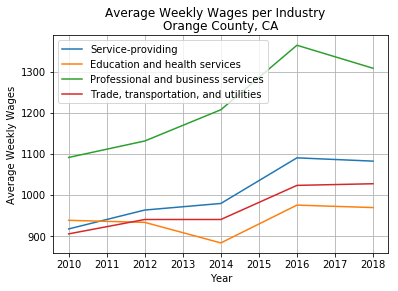

In [20]:
# Call Wage Numbers
stat = 'Average Weekly Wage'  
# Statistic associated with industry:: Establishment Count,Average Weekly Wage,September Employment
wage_dic = {}
for i in industry:
    tsearch = i
    rook = search_industrydata_cleaner(collect,stat,tsearch)
    wage_dic[i] = rook
# Plot
for i in industry:
    plt.plot(years,wage_dic[i],label=i)
    plt.suptitle('Average Weekly Wages per Industry')
    plt.ylabel('Average Weekly Wages')
    plt.xlabel('Year')
    plt.title(name)
    plt.legend()
plt.grid()
print(wage_dic)

**Regressions**

Here I start to play around with regressions. The cell immediately below I used to regress Drug Possesion arrests on employment numbers in the service industry *for the searched [individual] county*.

C:\Users\Matt\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     137.9
Date:                Tue, 16 Apr 2019   Prob (F-statistic):            0.00133
Time:                        19:08:27   Log-Likelihood:                -53.528
No. Observations:                   4   AIC:                             109.1
Df Residuals:                       3   BIC:                             108.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            61.7917      5.262     11.742      0.0

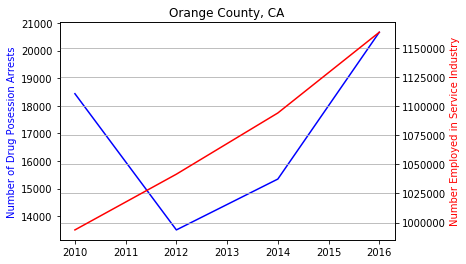

In [22]:
ind_vars = crime_dic['DRGPOSS']
dep_vars = emp_dic['Service-providing'][:-1] 
# Number of establishments per service providing industry
# Number of Drug Possesions in county

# Note the difference in argument order
model = sm.OLS(dep_vars, ind_vars).fit()
predictions = model.predict(ind_vars) # make the predictions by the model

# Print out the statistics
print(model.summary())

fig, ax1 = plt.subplots()
ax1.plot(years[:-1],crime_dic['DRGPOSS'],color='b',label='Number of Drug Posession Arrests')
ax1.set_ylabel('Number of Drug Posession Arrests', color='b')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(years[:-1],emp_dic['Service-providing'][:-1],color='r',label='Number of Service Industry Establishments')
ax2.set_ylabel('Number Employed in Service Industry', color='r')
plt.title(name)
plt.grid()
print("\n Number of Jobs in the Service Industry plotted against number of drug posession arrests.")

Here is where I figured out how to format the data for multiple regression testing (even if the regression numbers themselves are still junk).

In [37]:
# Multiple Regression Testing
multireg_dic = {}    
for i in wage_dic:  # For each industry in the wage dictionary
    multireg_dic[i+" wages"] = wage_dic[i][:-1] # Add wage data to new dictionary, retitle for calraification
    multireg_dic[i+" jobs"] = emp_dic[i][:-1]  # Add employment numbers per industry, retitle for calarification
# Now we have employment and wage data in a single dictionary    

multireg = pd.DataFrame(data=multireg_dic)  # Convert dictionary into a dataframe
x = multireg[list(multireg.columns.values)[:3]]  # Use only the first 3 columns to regress
y = crime_dic['DUI']  # Set y variable

model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

print('Crime Dictionary (y vars): ',crime_dic)
print(model.summary())

Crime Dictionary (y vars):  {'DRGPOSS': (18439, 13500, 15344, 20667), 'AGASSLT': (4557, 4307, 4216, 4764), 'DUI': (15955, 14633, 12615, 10826)}
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     808.6
Date:                Tue, 16 Apr 2019   Prob (F-statistic):             0.0258
Time:                        19:21:46   Log-Likelihood:                -28.172
No. Observations:                   4   AIC:                             62.34
Df Residuals:                       1   BIC:                             60.50
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err         

C:\Users\Matt\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


**Here is the start of my current problems.**

I am trying to create a dataframe of multiple economic and criminal variables across all years for my entire sample database. I was able to get the criminal data in the correct format, however my economic data is stuck in a series of arrays which I cannot run a regression on (though can still apparently graph, as illustrated below).

Sample Data:  dict_keys(['IN, Starke', 'IA, Decatur', 'SC, Greenwood', 'OH, Erie', 'MO, Phelps', 'TX, Johnson', 'MT, Fergus', 'PA, Lawrence', 'MN, Pine', 'KS, Pottawatomie']) 



,Service-providing,Education and health services,Professional and business services,"Trade, transportation, and utilities",DRGPOSS,AGASSLT,DUI
0,[242],[25],[29],[85],98,13,41
1,[245],[27],[31],[90],68,11,49
2,[221],[24],[24],[85],28,13,38
3,[233],[25],[27],[90],96,25,86
4,[127],[21],[13],[47],6,3,21


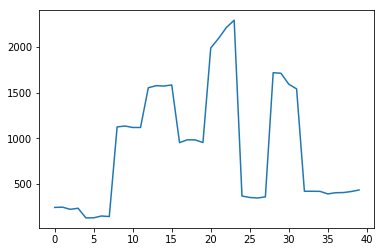

In [50]:
# Function for cleaning data sample database
def industrydata_cleaner(data,stat,tsearch):
    container = []
    for i in data:
        for n in range(len(data[i]['Industry'])-1):  # -1 because only for years of crime data
            x = data[i]['Industry'][n].loc[data[i]['Industry'][n]['Industry']== tsearch]
            x = x[stat].values
            #print(type(x))
            container.append(x)
    return container # Return a list of individual values
def sample_crime_cleaner(data,crime):
    container = []
    for i in data:
        for n in range(len(data[i]['Crime'])):
            y = data[i]['Crime'][n][crime]
            y = y.values
            #print(type(y))
            container.append(y[0])
    return container

test_dic = {}
stat = 'Establishment Count'
for n in industry:
    test_dic[n] = industrydata_cleaner(samp_db,stat,n)
    
for i in crimes:
    test_dic[i] = sample_crime_cleaner(samp_db,i)
test = pd.DataFrame(data=test_dic)
print("Sample Data: ",samp_db.keys(),'\n')
#print("Test Dictonary: ",test_dic.keys())

plt.plot(test['Service-providing'])
test.head()

Here I deviate from "good coding practice" to try and get my dataframe out of arrays. I tried hardcoding the specific industries and looping through the data to pull the specific values.

In the end, it worked..

In [44]:
serv_col = [i[0] for i in test_dic["Service-providing"]]
serv_colpd = pd.Series(serv_col)
test['Service-providing'] = serv_colpd

# Education and health services
edu_list = np.array([])
for i in test_dic["Education and health services"]:
    try:
        edu_list = np.append(edu_list,i[0])
    except:
        edu_list = np.append(edu_list,0)
edu_colpd = pd.Series(edu_list)
test['Education and health services'] = edu_colpd

# Professional and business services
prof_list = np.array([])
for i in test_dic["Professional and business services"]:
    try:
        prof_list = np.append(prof_list,i[0])
    except:
        prof_list = np.append(prof_list,0)
edu_colpd = pd.Series(prof_list)
test['Professional and business services'] = edu_colpd

trade_col = [i[0] for i in test_dic["Trade, transportation, and utilities"]]
trade_colpd = pd.Series(serv_col)
test['Trade, transportation, and utilities'] = trade_colpd

In [45]:
test

,Service-providing,Education and health services,Professional and business services,"Trade, transportation, and utilities",DRGPOSS,AGASSLT,DUI
0,242,25.0,29.0,242,98,13,41
1,245,27.0,31.0,245,68,11,49
2,221,24.0,24.0,221,28,13,38
3,233,25.0,27.0,233,96,25,86
4,127,21.0,13.0,127,6,3,21
5,128,19.0,11.0,128,6,3,18
6,148,26.0,16.0,148,6,3,17
7,142,27.0,17.0,142,8,5,8
8,1124,156.0,189.0,1124,389,231,372
9,1134,160.0,190.0,1134,370,241,463


However its still a very weak regression (and probably not statistically sound, as indicated by the large R-squared?)

In [47]:
x = test[list(test.columns.values[:4])]  # Use only the first 3 columns to regress
y = test['DUI']  # Set y variable

model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    DUI   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     109.1
Date:                Tue, 16 Apr 2019   Prob (F-statistic):           1.99e-18
Time:                        19:30:00   Log-Likelihood:                -228.32
No. Observations:                  40   AIC:                             462.6
Df Residuals:                      37   BIC:                             467.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Here Im just using another method to do the same regression.

In [48]:
model23 = smf.ols(formula = 'y ~ x', data= test)
f_lin_reg = model23.fit()
f_lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     34.73
Date:                Tue, 16 Apr 2019   Prob (F-statistic):           1.00e-10
Time:                        19:30:01   Log-Likelihood:                -228.08
No. Observations:                  40   AIC:                             464.2
Df Residuals:                      36   BIC:                             470.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.1085     21.174      0.666      0.509     -28.835      57.052
x[0]           0.0630      0.071      0.884      0.383      -0.082       0.208
x[1]           0.0280      0.250      0.112      0.912      -0.479       0.535
x[2]           0.3413      0.726      0.470      0.641      -1.132       1.814
x[3]           0.0630      0.071      0.884      0.383      -0.082       0.208
==============================================================================
Omnibus:                       11.303   Durbin-Watson:                   0.657
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.871
Skew:                           0.744   Prob(JB):                     0.000358
Kurtosis:                       5.703   Cond. No.                     1.82e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.09e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""